In [1]:
import matplotlib
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  
import numpy.ma as ma
import scipy.cluster
DEFAULT_DPI = 600
matplotlib.rcParams['figure.figsize'] = (15, 8)

In [2]:
# load data
data3_rows = np.loadtxt('/home/dante/SHAD/dataset3',delimiter='\t')
data3_cols = data3_rows.T


In [37]:
# for visualization:
# pd.DataFrame(data3_rows)


### Define abnormality as rate of "how often does current object appear in the tails of distributions"

In [40]:
# calculate abnormality
p1=[]
p5=[]
p95=[]
p99=[]

N, K = data3_rows.shape

for i in range(0,K):
    p1.append(np.percentile(data3_cols[i], 1))
    p5.append(np.percentile(data3_cols[i], 5))
    p95.append(np.percentile(data3_cols[i], 95))
    p99.append(np.percentile(data3_cols[i], 99))

#print p1, p5,p95,p99

abnormality = {}
for i in range(0, N):
    abnormality[i]=0
    for j in range(0, K):
        c = data3_rows[i][j]        
        # 1 point of abnormalito for getting into top or bottom 5%
        # +2 extra points of abnormality for getting into top or bottom 1%
        abnormality[i] += 2*(c < p1[j]) + (c < p5[j]) + (c > p95[j]) + 2*(c > p99[j])

#print some top abnormality examples
abn_sorted = sorted(abnormality.iteritems(), key=lambda (k,v): v, reverse =True)

for k, v in abn_sorted[:10]:
    print k, v

2070 28
366 26
3123 26
2518 25
2099 24
828 22
1995 22
4003 22
971 21
2354 21


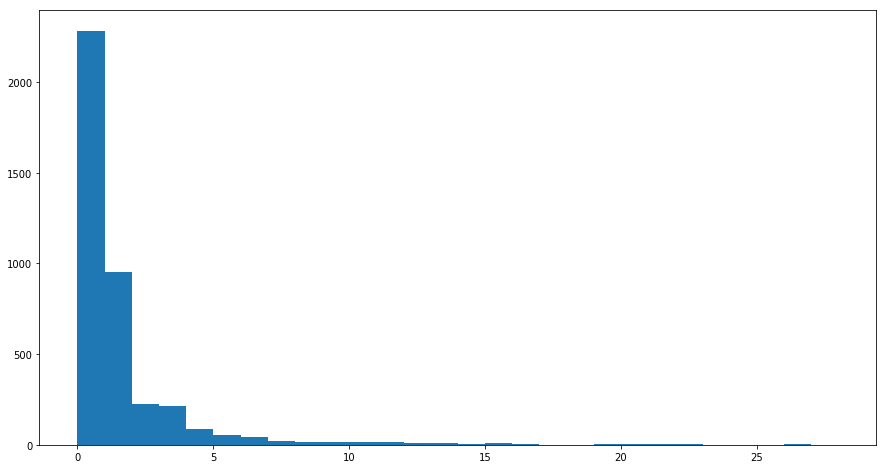

In [25]:
plt.hist(abnormality.values(),28,range=[0,28])
# plt.hist(abnormality.values(),22,range=[6,28])
print "" 

In [23]:
# average abnormality 
print np.mean(abnormality.values()), np.std(abnormality.values())


1.14973795857 2.51395690941


### Run clusterization and check abnormality of clusters

In [201]:
# K-means clustering
nclusters = 8

centroid, label = scipy.cluster.vq.kmeans2(data3_rows, nclusters, iter=100, thresh=1e-05, minit='random', missing='warn')
# result of this k-means is unstable, changes when you recalculate the cell


# small trick, explained below
def truevar(x): 
    return np.var(x)

# put abnormality and cluster_id into DataFrame to easily calculate stats:
df_abn = pd.DataFrame(abnormality.values(), columns=[['abn']])
df_label = pd.DataFrame(label, columns=[['cluster_id']])
cluster_stats = pd.concat([df_abn, df_label], axis=1)\
.pivot_table(
    index='cluster_id',
    values='abn',
    aggfunc=[len, np.mean, np.std, truevar]
)

# reorder axis to make cluster_stats look simpler
cluster_stats2 = cluster_stats.reorder_levels([1,0], axis=1)['abn']
cluster_stats2


,len,mean,std,truevar
cluster_id,,,,
0,1165,0.821459,1.508528,2.273703
1,270,1.229630,1.194415,1.421344
2,1352,0.405325,0.794076,0.630090
3,183,2.234973,2.342742,5.458449
4,295,1.427119,2.135052,4.542993
5,29,8.965517,7.321606,51.757432
6,267,5.977528,5.634836,31.632454
7,446,0.264574,0.615858,0.378431


### Calculate variance of abnormality inside clusters

In [207]:
# calculate within-cluster variance and % of total variance explained
cluster_stats2['var_in_cluster'] = cluster_stats2['truevar'] * cluster_stats2['len'] / sum(cluster_stats2['len'])
totvar = np.var(abnormality.values())
cluster_stats2['var_in_cluster_%'] = cluster_stats2['var_in_cluster'] / totvar

print ''
print 'total abnormality variance: %s' % totvar
print 'abnormality variance explained by between-cluster variance: %.2f%%' % ((1-sum(cluster_stats2['var_in_cluster_%'])) *100 )
print 'abnormality variance left inside clusters: %.2f%%' % (sum(cluster_stats2['var_in_cluster_%']) *100 )

cluster_stats2



total abnormality variance: 6.43815486612
abnormality variance explained by between-cluster variance: 36.66%
abnormality variance left inside clusters: 63.34%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
cluster_id,,,,,,
0,1165,0.821459,1.508528,2.273703,0.661059,0.102678
1,270,1.229630,1.194415,1.421344,0.095773,0.014876
2,1352,0.405325,0.794076,0.630090,0.212598,0.033022
3,183,2.234973,2.342742,5.458449,0.249288,0.038720
4,295,1.427119,2.135052,4.542993,0.334460,0.051950
5,29,8.965517,7.321606,51.757432,0.374586,0.058182
6,267,5.977528,5.634836,31.632454,2.107778,0.327388
7,446,0.264574,0.615858,0.378431,0.042121,0.006542


### 30-40% of variance is between-cluster variance, depending on clusterization. Not very impressive, but better than nothing.

### Remark: Don't trust anyone

Why did we have to define **truevar** function, which is no more than just a replica of np.var? Why couldn't we run pd.pivot_table with np.var in aggfunc parameter?

Because if you run np.var inside pd.pivot_table, you'll appear to find 
$\sqrt\frac {\sum(x_i - mean)^2}{N-1}$
as a result of calculation, instead of 
$\sqrt\frac {\sum(x_i - mean)^2}{N}$

Problem is in ddof (degrees of freedom) parameter. Looks like in pivot_table python implicitly switches from np.var() to pd.DataFrame.var() function, which has ddof=1 by default:
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.var.html

compare:

print np.var(df_abn)

print df_abn.var()




### Now let's try to use time (hour) of first user appearance as natural clusterization

In [208]:
# natural clusterization

df_abn = pd.DataFrame(abnormality.values(), columns=[['abn']])
df_label2 = pd.DataFrame(data3_cols[1], columns=[['hour']])

cluster_stats_hour = pd.concat([df_abn, df_label2], axis=1)\
.pivot_table(
    index='hour',
    values='abn',
    aggfunc=[len, np.mean, np.std, truevar]
)\
.reorder_levels([1,0], axis=1)['abn']

# calculate within-cluster variance and % of total variance explained
cluster_stats_hour['var_in_cluster'] = cluster_stats_hour['truevar'] * cluster_stats_hour['len'] / sum(cluster_stats_hour['len'])
cluster_stats_hour['var_in_cluster_%'] = cluster_stats_hour['var_in_cluster'] / totvar

print ''
print 'total abnormality variance: %s' % totvar
print 'abnormality variance explained by between-cluster variance: %.2f%%' % ((1-sum(cluster_stats_hour['var_in_cluster_%'])) *100 )
print 'abnormality variance left inside clusters: %.2f%%' % (sum(cluster_stats_hour['var_in_cluster_%']) *100 )

cluster_stats_hour


total abnormality variance: 6.43815486612
abnormality variance explained by between-cluster variance: 1.39%
abnormality variance left inside clusters: 98.61%


,len,mean,std,truevar,var_in_cluster,var_in_cluster_%
hour,,,,,,
0.0,51,1.411765,0.725988,0.516724,0.006577,0.001022
1.0,386,1.709845,3.249576,10.532390,1.014600,0.157592
2.0,93,1.333333,2.968433,8.716846,0.202313,0.031424
3.0,63,1.444444,2.781145,7.611993,0.119679,0.018589
4.0,43,1.348837,3.123518,9.529475,0.102263,0.015884
5.0,60,0.916667,2.117655,4.409722,0.066030,0.010256
6.0,89,1.157303,3.129402,9.683121,0.215073,0.033406
7.0,158,1.253165,2.789737,7.733376,0.304935,0.047364
8.0,253,1.264822,3.194276,10.163071,0.641691,0.099670


### Between-groups variance is almost 0, natural clusterization doesn't differentiate users in terms of abnormality

(array([  51.,  386.,   93.,   63.,   43.,   60.,   89.,  158.,  253.,
         297.,  341.,  251.,  211.,  192.,  170.,  171.,  166.,  163.,
         207.,  159.,  141.,  140.,  112.,   90.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

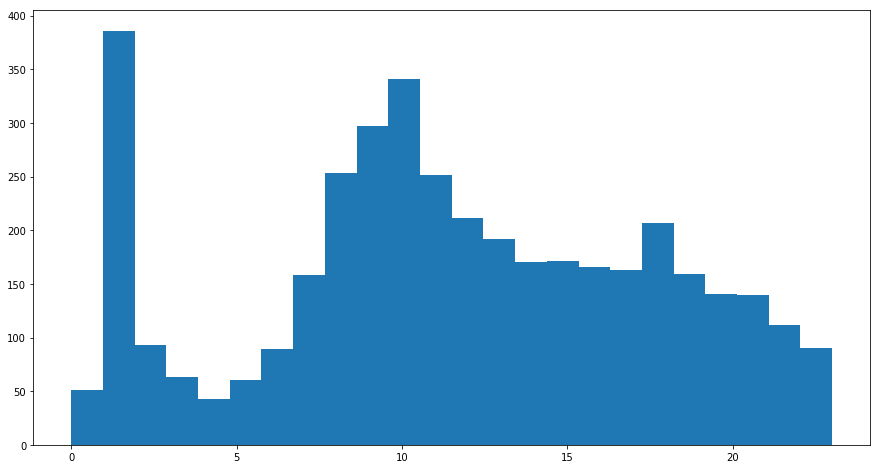

In [209]:
plt.hist(data3_cols[1], 24)

# hmm, something strange at 1:00 am...